# Section 8

## Preliminaries

### Data Sources
This repository contains two files named `radioflat.txt` and `radiosteep.txt`, which you will need for the excercises in this section. 

## Assignment

Complete the following problems. Use code cells to develop and run any Python code required and Markdown cells to respond to any auxilliary questions that ask you to interpret your results.

### Exercise 1 (AST4031 & AST5031):

[Masson & Wall (1977)](http://adsabs.harvard.edu/abs/1977MNRAS.180..193M) examined the luminosity functions of so-called flat and steep radio spectrum quasars to study the cosmological evolution of these objects. Today you'll perform your own assessment on whether or not these two samples come from the same parent distribution. The data for their simple source count distributions are available below for both the steep and flat spectrum quasars in their study.
1. Write your own functions to compute data binning according to Scott's Rule and the Freedman-Diaconis Rule. Compare the data binned according to these rules to matplotlib's default binning. Choose a binning strategy and explain your choice.
2. Plot the frequency histograms for the steep spectrum and flat spectrum quasars. Include error bars in your plot. Discuss your calculation of the errors.
3. Comment qualitatively on the relative appearance of these 2 histograms.
4. Plot the cumulative frequency distributions of the two samples.
5. Use scipy's 2-sample Kolmogorov-Smirnov test to quantitatively address whether the parent distributions of these 2 object classes are the same.
6. Use scipy's $U$ test to compare the 2 samples and address whether the parent distributions of these 2 object classes are the same. How does this test compare with the answer from the Kolmogorov-Smirnov test?

In [1]:
import numpy as np
import astropy as ap
import astropy.io.ascii as apascii

import matplotlib
import matplotlib.pyplot as mplplot

import scipy.stats as spstats

%matplotlib inline
%load_ext lab_black

Let's start by reading in the data. Since they're stored in text files we'll use the [`astropy.ascii.read` function](http://docs.astropy.org/en/stable/api/astropy.io.ascii.read.html) to parse the data directly into `astropy.table.Table` data structures.

We'll keep the tables in a dict so that we can reference the data easily by quasar type i.e. _steep_ or _flat_ spectrum.

In [2]:
quasarData = {}
quasarData["flat"] = apascii.read(
    "radioflat.txt", data_start=0, names=["b_mag"]
)
quasarData["steep"] = apascii.read(
    "radiosteep.txt", data_start=0, names=["b_mag"]
)

One of our data files has a spurious, zero-valued magnitude as its final entry. A magnitude of zero would imply an extremely bright object. This highlights the importance of checking the validity of our data before analysing it. Now we can filter out any magnitudes brighter than zero before proceeding to plot our data.

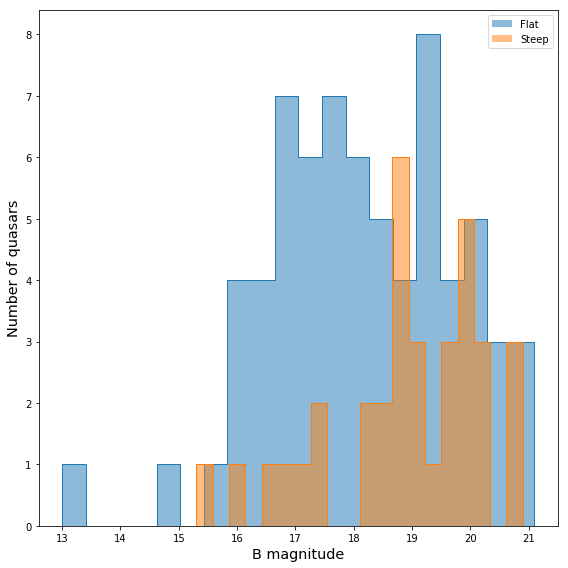

In [3]:
quasarData["flat"]["b_mag"] = quasarData["flat"]["b_mag"][
    quasarData["flat"]["b_mag"] > 0
]
quasarData["steep"]["b_mag"] = quasarData["steep"]["b_mag"][
    quasarData["steep"]["b_mag"] > 0
]

plotDataAxes = mplplot.figure(figsize=(8, 8)).add_subplot(1, 1, 1)

for enumerator, quasarType in enumerate(quasarData.keys()):
    plotDataAxes.hist(
        quasarData[quasarType]["b_mag"],
        bins=20,
        label=quasarType.title(),
        alpha=0.5,
        fc="C{}".format(enumerator),
    )
    plotDataAxes.hist(
        quasarData[quasarType]["b_mag"],
        bins=20,
        histtype="step",
        ec="C{}".format(enumerator),
        label=None,
    )

plotDataAxes.set_xlabel("B magnitude", fontsize="x-large")
plotDataAxes.set_ylabel("Number of quasars", fontsize="x-large")
plotDataAxes.legend()
mplplot.tight_layout()

We'll define two functions that implement the _Freedman Draconis_ and _Scott_ binning methods that were specified in the lectures. These functions will return an array of bin boundaries that conform with the corresponding binning rule. 

In [4]:
def freedmanDraconisBins(data):
    percentiles = np.percentile(q=[25, 75], a=data)
    binWidth = 2.0 * np.diff(percentiles)[0] / np.cbrt(data.size)
    bins = np.arange(start=data.min(), stop=data.max(), step=binWidth)
    ## Must add one more boundary beyond the range of the data.
    bins = np.append(bins, bins[-1] + binWidth)
    return bins


def scottBins(data):
    binWidth = 3.5 * data.std() / np.cbrt(data.size)
    bins = np.arange(start=data.min(), stop=data.max(), step=binWidth)
    bins = np.append(bins, bins[-1] + binWidth)
    ## Must add one more boundary beyond the range of the data.
    return bins

Now we'll create some data structures to provide easy access to our plotting functions, data, histograms and error intervals. This will make out plotting code more streamlined!

Note that we can use [`dict` comprehensions](https://www.datacamp.com/community/tutorials/python-dictionary-comprehension) to quickly generate new dictionaries using the structure of existing ones.

In [5]:
binningFunctions = {
    "SR": scottBins,
    "FD": freedmanDraconisBins,
    "MPL": lambda data: 10,
}

binningSpecs = {
    "flat": {key: None for key in binningFunctions.keys()},
    "steep": {key: None for key in binningFunctions.keys()},
}

histograms = {
    "flat": {key: None for key in binningFunctions.keys()},
    "steep": {key: None for key in binningFunctions.keys()},
}

intervals = {
    "flat": {key: None for key in binningFunctions.keys()},
    "steep": {key: None for key in binningFunctions.keys()},
}

## Compute and store the bin boundaries for each binning method
for quasarType, binningSpec in binningSpecs.items():
    for binningAlgorithm in binningSpec.keys():
        binningSpec[binningAlgorithm] = binningFunctions[binningAlgorithm](
            quasarData[quasarType]["b_mag"]
        )

Now we can plot the distribution of B magintude for _flat_ and _steep_ spectrum quasars using the three binning methods, including the matplotlib default of 10 bins.

The number of galaxies in each bin is small enough that Poisson intervals are appropriate estimates of the bin contents. We devoted a whole previous section to the calculation of Poisson intervals. For this excercise, we'll jsut use the `interval` method of the `spstats.poisson` class. The method returns an upper and lower bound on the true frequency of events in the binning interval when supplied with the measured value of the bin contents. Note that some manipulation is needed to plot the errors, which `matplotlib` expects to be provided as offsets from the central value (bin contents).

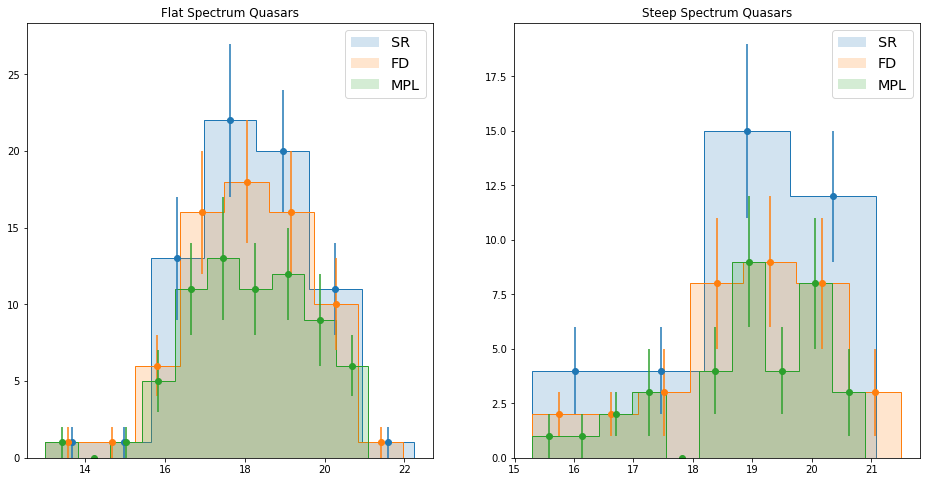

In [6]:
magBinningFigureShape = np.array([len(binningSpecs), 1])
magBinningFigure, magBinningPanels = mplplot.subplots(
    figsize=magBinningFigureShape * 8,
    nrows=magBinningFigureShape[1],
    ncols=magBinningFigureShape[0],
)

for magBinningPanel, (quasarType, quasarMagnitudes) in zip(
    magBinningPanels, quasarData.items()
):
    for enumerator, (binningAlgorithm, binningSpec) in enumerate(
        binningSpecs[quasarType].items()
    ):
        colourSpec = "C{}".format(enumerator)
        magBinningPanel.hist(
            quasarMagnitudes["b_mag"],
            bins=binningSpec,
            label=binningAlgorithm,
            alpha=0.2,
            fc=colourSpec,
            density=False,
        )
        histograms[quasarType][
            binningAlgorithm
        ], bins, _ = magBinningPanel.hist(
            quasarMagnitudes["b_mag"],
            bins=binningSpec,
            histtype="step",
            label=None,
            ec=colourSpec,
            density=False,
        )

        intervals[quasarType][binningAlgorithm] = spstats.poisson(
            mu=histograms[quasarType][binningAlgorithm]
        ).interval(alpha=0.68)

        binCentres = 0.5 * (bins[:-1] + bins[1:])

        errors = (
            histograms[quasarType][binningAlgorithm]
            - intervals[quasarType][binningAlgorithm][0],
            intervals[quasarType][binningAlgorithm][1]
            - histograms[quasarType][binningAlgorithm],
        )

        magBinningPanel.errorbar(
            binCentres,
            histograms[quasarType][binningAlgorithm],
            yerr=errors,
            ls="none",
            marker="o",
            c=colourSpec,
        )

    magBinningPanel.legend(fontsize="x-large")
    magBinningPanel.set_title("{} Spectrum Quasars".format(quasarType.title()))

For the flat-spectrum quasars, the overall distribution is quite symmetric and continuous. All binning methods perform reasonably well. For steep spectrum quasars the distribution is skewed and more sparse. The Freedman-Draconis rule achieves the best trade-off between representing the data and achieving a good signal-to-noise ratio.

We can write a very simple function to compute the CDF (or technically the EDF) of a data array. We simply sort our input array, then use the [`numpy.cumsum` function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html) to compute the cumulative sum, starting from the lowest value, before normalizing by the sum of the values in the array.

In [7]:
def computeCDF(data):
    sortedData = np.sort(np.array(data).astype(float))
    cdf = np.cumsum(sortedData) / np.sum(sortedData)
    return sortedData, cdf

Now we can plot the CDF/EDF for each quasar type, we'll plot the CDF/EDF of the other type for reference and indicate the abscissae locations for the data along the _B magintude_ axis. 

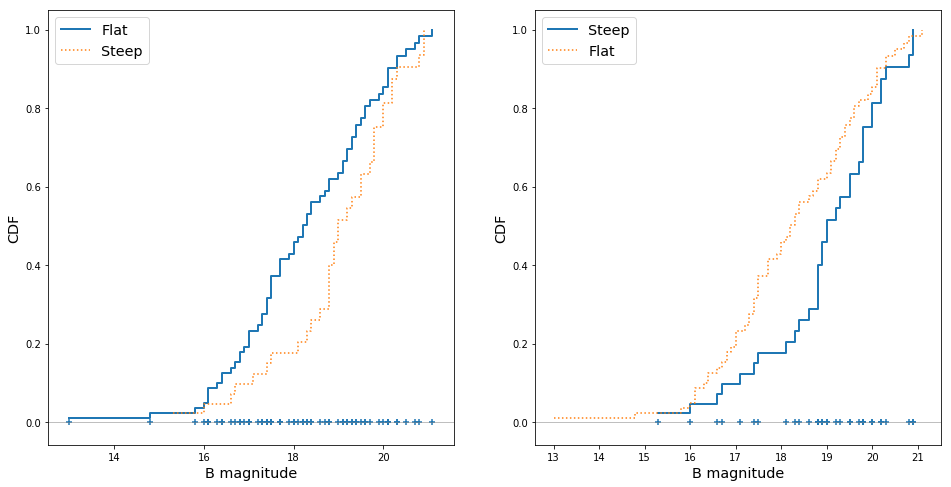

In [8]:
cdfFigure, cdfPanels = mplplot.subplots(
    figsize=magBinningFigureShape * 8,
    nrows=magBinningFigureShape[1],
    ncols=magBinningFigureShape[0],
)

quasarCdfs = {
    quasarType: computeCDF(quasarMagnitudes)
    for quasarType, quasarMagnitudes in quasarData.items()
}

for cdfPanel, (quasarType, quasarCdf) in zip(cdfPanels, quasarCdfs.items()):
    cdfPanel.step(*quasarCdf, label=quasarType.title(), where="post", lw=2)
    cdfPanel.scatter(
        np.sort(np.array(quasarData[quasarType]["b_mag"]).astype(float)),
        np.zeros_like(np.array(quasarData[quasarType]["b_mag"]).astype(float)),
        marker="+",
    )
    cdfPanel.axhline(y=0, color="grey", lw=0.5)

    cdfPanel.legend(fontsize="x-large")
    cdfPanel.set_xlabel("B magnitude", fontsize="x-large")
    cdfPanel.set_ylabel("CDF", fontsize="x-large")

for cdfPanel, (quasarType, quasarCdf) in zip(
    np.flipud(cdfPanels), quasarCdfs.items()
):
    cdfPanel.step(
        *quasarCdf, label=quasarType.title(), where="post", linestyle="dotted"
    )

    cdfPanel.legend(fontsize="x-large")
    cdfPanel.set_xlabel("B magnitude", fontsize="x-large")
    cdfPanel.set_ylabel("CDF", fontsize="x-large")

### How to implement two-sample Kolmogorov Smirnoff test
The two-sample Kolmogorov Smirnoff test compares the _empirical distribution functions_ (EDFs, $F_{1,n}$, $F_{2,m}$) of two data samples (with sizes $m$ and $n$) to detemine whether the _null hypothesis_ - that both samples are drawn from the same parent population - is likely to be true. The test proceeds by computing the maximum absolute difference between the EDFs 
\begin{equation}
\displaystyle D_{n,m}=\sup_{x}|F_{1,n}(x)-F_{2,m}(x)|
\end{equation}
Extreme values of $D_{n,m}$ imply that the _null hypothesis_ ($H_{0}$) is **false** and that the two samples are drawn from **different** parent populations. Specifically, the $H_{0}$ can be rejected with significance level $\alpha$ if
\begin{equation}
D_{n,m}>c(\alpha){\sqrt {\frac {n+m}{nm}}}
\end{equation}
where 
\begin{equation}
c(\alpha)\approx\sqrt{-\frac{1}{2}\ln\alpha}
\end{equation}

We now require an algorithm to compute $D_{n,m}$, given $F_{1,n}$ and $F_{2,m}$. Assuming that our data samples, $X_{1,n}$ and $X_{2,m}$ are sorted, a common approach (in fact the one used by `scipy` in its implementation) begins by forming the **sorted union** ($X_{1,n} \cup X_{2,m}$) of the separate samples. 

Now, for each value $x_{i}$ in $X_{1,n} \cup X_{2,m}$, we find the **largest indices** $z_{1,i}$ and $z_{2,i}$ into $X_{1,n}$ and $X_{2,m}$ respectively, at which $x_{i}$ could be inserted to yeild modified arrays $X\prime_{1,n+1}$ and $X\prime_{2,m+1}$ that remains sorted. This process is used to generate two arrays of indices, $Z_{1,n+m}$ and $Z_{2,n+m}$ with the same number of elements as the union array and (potentially repeated) entries drawn from the indices of $X_{1,n}$ and $X_{2,m}$. Consider the following example:

\begin{align}
&X_{1,n} = \{1,2,3,4,5,6,7,8,9,10\},\,n=10\\
&X_{2,n} = \{1,2,3,5,7,11,13,17,19\},\,m=9\\
\implies& X_{1,n} \cup X_{2,m} = \{1,1,2,2,3,4,5,5,6,7,7,8,9,10,11,13,17,19\}\\
\end{align}
This yields the following arrays of insertion indices, starting from zero and remembering that we want the *highest* possible index.
\begin{align}
&Z_{1,n+m} = \{1,1,2,2,3,4,5,5,6,7,7,8,9,10,10,10,10,10\}\\
&Z_{2,n+m} = \{1,1,2,2,3,3,4,4,4,5,5,5,5,5,6,7,8,9\}
\end{align}

The elements of $Z_{1,n+m}$ and $Z_{2,n+m}$ count the number of elements in $X_{1,n}$ and $X_{2,m}$ with values strictly less than the corresponding entry in $X_{1,n} \cup X_{2,m}$. If we normalize $Z_{1,n+m}$ and $Z_{2,n+m}$ by $n$ and $m$ respectively then we have computed the values of the EDFs of $X_{1,n}$ and $X_{2,m}$ at the abscissa of the corresponding entry in $X_{1,n} \cup X_{2,m}$. The reason this works is that only the **ordering**, and the **overall sum** of the sample abscissae matter when calculating the EDF, the specific **values** of the **individual** EDF abscissae aren't important.
\begin{align}
&\frac{Z_{1,n+m}}{n} = \{1/10,1/10,2/10,2/10,3/10,4/10,5/10,5/10,6/10,7/10,7/10,8/10,9/10,10/10,10/10,10/10,10/10,10/10\}\\
&\frac{Z_{2,n+m}}{m} = \{1/9,1/9,2/9,2/9,3/9,3/9,4/9,4/9,4/9,5/9,5/9,5/9,5/9,5/9,6/9,7/9,8/9,9/9\}
\end{align}

Now we can simply subtract the two normalized arrays and find the maximum absolute difference - easy!

\begin{equation}
D_{n,m}=\sup_{x}|F_{1,n}(x)-F_{2,m}(x)| = \max\left|\frac{Z_{1,n+m}}{n} - \frac{Z_{2,n+m}}{m}\right|
\end{equation}

It's not difficult to write an algorithm to find the inertion indices $Z_{1,n+m}$ and $Z_{2,n+m}$ but the `scipy` implementation uses `numpy`'s [`searchsorted` function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.searchsorted.html) for efficiency.

After all that, we can just use the [`scipy.stats.ks_2samp` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) to compute the Kolmogorov statistic and significance level for our data.

In [9]:
ksResult = spstats.ks_2samp(*quasarData.values())
print(ksResult)

Ks_2sampResult(statistic=0.30890269151138716, pvalue=0.018224112861272748)


The $p$-value returned by `ks_2samp` indicates that under the null hypothesis that both samples were drawn from the same parent population, there is less than a 2% chance of observing a Kolmogorov statistic value greatar than or equal to that which was derived. This is strong evidence that the _B magnitude_ distributions of the two quasar types are not drawn from the same parend distributions. 

For the final question, we'll use the `scipy.stats.mannwhitneyu` function to compute the $U$ statistic and the corresponding $p$-value for our data.

In [10]:
uResult = spstats.mannwhitneyu(*quasarData.values())
print(uResult)

MannwhitneyuResult(statistic=857.0, pvalue=0.008007259420657152)


In this case the $p$-value is even smaller, reinforcing our original conclusion that the two samples are inconsistent with being drawn from the same parent distribution. Moreover, since we have seen that the two distribution shapes differ primarily in the extended tail of the _steep_-spectrum quasars, we should expect the $U$ test to be more powerful. The reliance of the KS test on the EDF makes it insensitive to differences in the tails of the distributions being compared.